Copyright 2019 José Suárez-Varela, Sergi Carol-Bosch, Krzysztof Rusek, Paul Almasan, Marta Arias, Pere Barlet-Ros, Albert Cabellos-Aparicio.

Universitat Politècnica de Catalunya, AGH University of Science and Technology

Licensed under the MIT License (the "License"), see end.

# Challenging the generalization capabilities of Graph Neural Networks for network modeling

## ACM SIGCOMM Posters and Demos 2019

First we will download the datasets used in this demo. For this follow the instructions provided 
in the [How To Guide](https://github.com/knowledgedefinednetworking/demo-routenet). These datasets 
include 480,000 samples from three different topologies (14-node NSF network topology, 
24-node Geant2 network topology and 50-node network topology), with different routing schemes and 
variable input traffic matrices. Also, in this link you can find some instructions on how to train 
a RouteNet model from scratch using our datasets and the RouteNet implementation we provide in our 
GitHub repository. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from routenet.comnet_model import ComnetModel
from routenet.new_parser import NewParser
from routenet.tf_utils import _int64_feature, _int64_features, _float_features
%load_ext autoreload
%autoreload 2

Second is to load a RouteNet model already trained, for this we need to apply the same 
hyperparamters values used in the training. The following code specifies such 
hyperparameters. 

In [2]:
hparams = tf.contrib.training.HParams(link_state_dim=32,
                                      path_state_dim=32,
                                      T=8,
                                      readout_units=256,
                                      learning_rate=0.001,
                                      dropout_rate=0.5,
                                      l2=0.1,
                                      l2_2=0.01,
                                      learn_embedding=True) 


W0804 19:06:35.603255 4634047936 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The following code block loads some functions used to process the datasets:

In [3]:
def parse(serialized, target='delay'):
    '''
    Target is the name of predicted variable
    '''
    with tf.device("/cpu:0"):
        with tf.name_scope('parse'):
            features = tf.parse_single_example(
                serialized,
                features={
                    'traffic':tf.VarLenFeature(tf.float32),
                    target:tf.VarLenFeature(tf.float32),
                    'link_capacity': tf.VarLenFeature(tf.float32),
                    'links':tf.VarLenFeature(tf.int64),
                    'paths':tf.VarLenFeature(tf.int64),
                    'sequences':tf.VarLenFeature(tf.int64),
                    'n_links':tf.FixedLenFeature([],tf.int64),
                    'n_paths':tf.FixedLenFeature([],tf.int64),
                    'n_total':tf.FixedLenFeature([],tf.int64)
                })
            for k in ['traffic',target,'link_capacity','links','paths','sequences']:
                features[k] = tf.sparse_tensor_to_dense(features[k])
                if k == 'traffic':
                    features[k] = (features[k] - 0.17) / 0.13
                if k == 'link_capacity':
                    features[k] = (features[k] - 25.0) / 40.0

    return {k:v for k,v in features.items() if k is not target },features[target]

def read_dataset():
    ds = tf.data.TFRecordDataset(sample_file)

    # We parse the serialized input from the file
    ds = ds.map(lambda buf: parse(buf))

    ds = ds.batch(1)

    it = ds.make_initializable_iterator()

    return it

# Delay prediction with RouteNet

In this section, we use our RouteNet model to predict the per-source/destination delay in a 
network scenario with a given input topology, a source-destination routing scheme and a traffic 
matrix.
 
First of all, we pick randomly a sample from our simulation datasets:

In [4]:
random.seed(13)
# Path to downloaded datasets
path = '../../data/nsfnetbw/tfrecords/train/'
filename = random.choice(os.listdir(path))
sample_file = path + filename
print(sample_file)

../../data/nsfnetbw/tfrecords/train/results_nsfnetbw_15_Routing_SP_k_34.tfrecords


Then, we load the model provided in our GitHub repository to produce delay predictions. For the 
predictions, we use the first sample from the file selected above:

In [5]:
graph_predict = tf.Graph()
with graph_predict.as_default():
    model = ComnetModel(hparams)
    model.build()

    it = read_dataset()
    features, label = it.get_next()

    with tf.name_scope('predict'):
        predictions = tf.map_fn(lambda x: model(x, training=True), features, dtype=tf.float32)

    preds = tf.squeeze(predictions)
    predictions = 0.54*preds + 0.37

W0804 19:06:35.766058 4634047936 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 19:06:35.965291 4634047936 deprecation.py:323] From <ipython-input-3-b12f62caef92>:37: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
W0804 19:06:36.623247 4634047936 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/autog

In [6]:
with tf.compat.v1.Session(graph=graph_predict) as sess:
    sess.run(tf.compat.v1.local_variables_initializer())
    sess.run(tf.compat.v1.global_variables_initializer())
    saver = tf.compat.v1.train.Saver()
    # path to the checkpoint we want to restore
    saver.restore(sess, '../trained_models/model.ckpt-260380')

    hats = []
    for i in range(50):
        sess.run(it.initializer)
        pred_Delay, label_Delay = sess.run([predictions, label])
        hats.append(pred_Delay)

    final_prediction = np.median(hats, axis=0)

W0804 19:06:38.986289 4634047936 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


At this point we have the per-source/destination delay values predicted by RouteNet. The following code generates some visual figures where we can compare the predictions from RouteNet with the real values (ground truth) produced by our network simulator. Given the large number of delay predictions (i.e. source-destination pairs) in a single sample of our dataset, we randomly sample some of the results and plot them.

In [7]:
num_paths = 40 # Set how many paths you want to visualize
ids = random.sample(range(0, len(final_prediction)), num_paths)
ids.sort()

sample_prediction = []
sample_label = []

for i in ids:
    sample_prediction.append(final_prediction[i])
    sample_label.append(label_Delay[0][i])

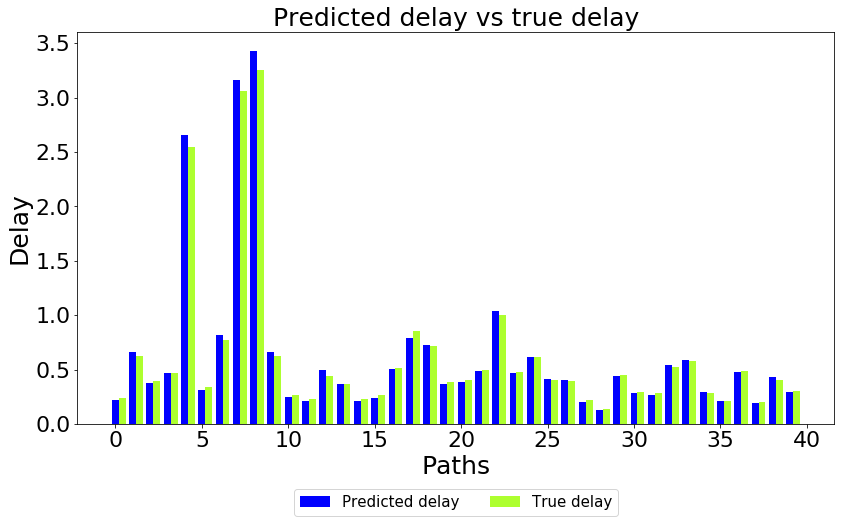

In [8]:
# create plot
fig, ax = plt.subplots()
index = np.arange(num_paths)
bar_width = 0.40

rects1 = plt.bar(index, sample_prediction, bar_width,
color='b',
label='Predicted delay')

rects2 = plt.bar(index + bar_width, sample_label, bar_width,
color='greenyellow',
label='True delay')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)

plt.xlabel('Paths',fontsize=25)
plt.ylabel('Delay',fontsize=25)
plt.title('Predicted delay vs true delay',fontsize=25)
plt.legend(loc='center',fontsize=15,bbox_to_anchor=(0.5, -0.20),fancybox=True,ncol=2)
plt.tight_layout()

fig = plt.gcf()
fig.set_size_inches(14, 8.5)

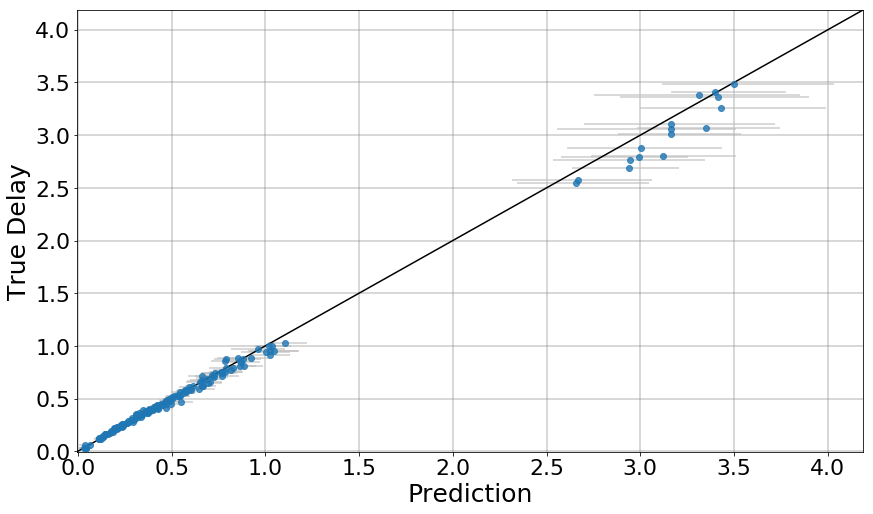

In [9]:
ax = plt.subplot()

xerr = [final_prediction - np.percentile(hats, q=5, axis=0),
        np.percentile(hats, q=95, axis=0) - final_prediction]

ax.errorbar(x=final_prediction, y=label_Delay[0], fmt='o', xerr=xerr, alpha=0.8, ecolor='silver')

m = max(label_Delay[0])
ax.plot([0, 1.3 * m], [0, 1.3 * m], 'k')
ax.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
ax.set_xlabel('Prediction', fontsize=25)
ax.set_ylabel('True Delay', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
ax.set_xlim(left=-0.002, right=1.2 * m)
ax.set_ylim(bottom=-0.005, top=1.2 * m)
fig = plt.gcf()
plt.tight_layout()
fig.set_size_inches(14, 8.5)

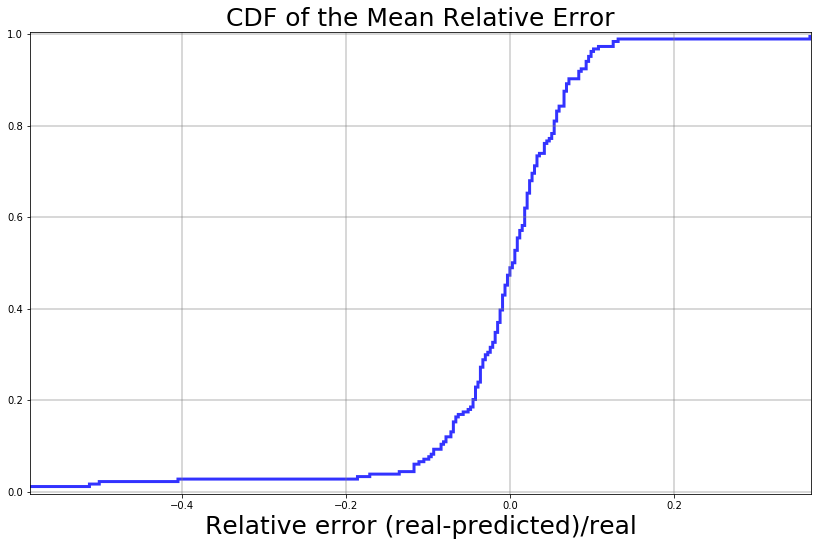

In [10]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

mre = (label_Delay-final_prediction)/label_Delay
mre = np.sort(mre)

mre = np.insert(mre, 0, -15.0)
mre = np.append(mre, 15.0)

plt.hist(mre, cumulative=True, 
         histtype='step', 
         bins=10000, 
         alpha=0.8, 
         color='blue', 
         density=True, 
         linewidth=3)
plt.ylim((-0.005, 1.005))
plt.xlim((mre[1], mre[-2]))
plt.xlabel("Relative error (real-predicted)/real", fontsize=25)
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
plt.title('CDF of the Mean Relative Error',fontsize=25)
fig = plt.gcf()
fig.set_size_inches(14, 8.5)

# References

Rusek, K., Suárez-Varela, J., Mestres, A., Barlet-Ros, P., & Cabellos-Aparicio, A. (2019, April). 
Unveiling the potential of Graph Neural Networks for network modeling and optimization in SDN. 
In Proceedings of the 2019 ACM Symposium on SDN Research (pp. 140-151). ACM.

In [11]:
#@title Licensed under the MIT License (the "License"); { display-mode:"form" }
# MIT License

# Copyright (c) 2019 Paul Almasan, José Suárez-Varela, Krzysztzof Rusek

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

